# File and libraries

In [52]:
import pandas as pd
import numpy as np


filepath=r'data/df_merch_7_bal_input'
test_filepath= f"{filepath}_test.csv"
train_filepath= f"{filepath}_train.csv"

sample_filepath=f"{filepath}_sample.csv"
test_sample_filepath=f"{filepath}_test_sample.csv"
train_sample_filepath=f"{filepath}_train_sample.csv"

file_tag = "Google Merch Shop"

# DSLabs functions

In [53]:
%run "scripts/dslabs_functions.py"


# Data functions

In [54]:
%run "scripts/data_functions.py"


data_functions lodaded


# Load

In [55]:

# test_data=True
test_data=False

# use to evaluate strategies. otherwise False to just transform data 
evaluate=True
# evaluate=False

if test_data==True:

    data=pd.read_csv(f"{filepath}.csv")
    
    test= pd.read_csv(test_filepath)
    train= pd.read_csv(train_filepath)

    # sample to test setup
    sample=0.005
    data = data.groupby('day_of_year').apply(lambda x: sample_per_day(x, sample)).reset_index(drop=True)
    test = test.groupby('day_of_year').apply(lambda x: sample_per_day(x, sample)).reset_index(drop=True)
    train = train.groupby('day_of_year').apply(lambda x: sample_per_day(x, sample)).reset_index(drop=True)

    
else:
    # data=pd.read_csv(f"{filepath}.csv")  
    # test= pd.read_csv(test_filepath)
    # train= pd.read_csv(train_filepath)

    # use 10% sample file when heavy processing
    data=pd.read_csv(sample_filepath)
    test= pd.read_csv(test_sample_filepath)
    train= pd.read_csv(train_sample_filepath)
 
 
target='returning_user'
target_metric='f2'
vars: list[str] = data.columns.to_list()
labels: list = list(data[target].unique())


# ensure sorting by day_of_year for correct splitting 
# "When in the presence of temporal data, data partition shall use older data to train and newer to test, in order to not use future data to classify past data. In any other case, partition shall be random."
data.sort_values(by='day_of_year', inplace=True)
test.sort_values(by='day_of_year', inplace=True)
train.sort_values(by='day_of_year', inplace=True)



data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 18170 entries, 0 to 18169
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   event_name             18170 non-null  float64
 1   device_language        18170 non-null  float64
 2   geo_region             18170 non-null  float64
 3   geo_city               18170 non-null  float64
 4   traffic_source_medium  18170 non-null  float64
 5   traffic_source_source  18170 non-null  float64
 6   engagement_time_msec   18170 non-null  float64
 7   day_of_year            18170 non-null  float64
 8   page_path_level_1      18170 non-null  float64
 9   path_length            18170 non-null  float64
 10  local_minute_sin       18170 non-null  float64
 11  local_minute_cos       18170 non-null  float64
 12  geo_country            18170 non-null  float64
 13  session_engaged        18170 non-null  float64
 14  is_weekend             18170 non-null  float64
 15  returni

# Distribution Check

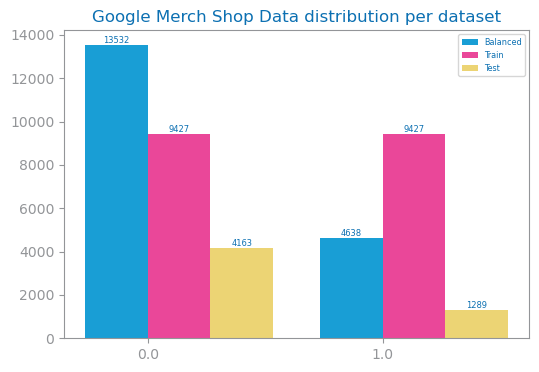

In [56]:
from pandas import concat
from matplotlib.pyplot import figure, show
from dslabs_functions import plot_multibar_chart


# Distribution check


# Create a dictionary to store original class counts
values: dict[str, list[int]] = {
    "Balanced": [
        len(data[data[target] == 0]),  # Assuming 0 is the negative class
        len(data[data[target] == 1]),  # Assuming 1 is the positive class
    ]
}

values["Train"] = [
    len(train[train[target] == 0]),
    len(train[train[target] == 1]),
]
values["Test"] = [
    len(test[test[target] == 0]),
    len(test[test[target] == 1]),
]

# Visualize the distribution
figure(figsize=(6, 4))
plot_multibar_chart(labels, values, title=f"{file_tag} Data distribution per dataset")
show()

# Model Evaluation Prep

In [57]:
trnX, tstX, trnY, tstY, labels, vars = read_train_test_from_files(train, test, target)
print(f'Train#={len(trnX)} Test#={len(tstX)}')
print(f'Labels={labels}')

Train#=18854 Test#=5452
Labels=[0.0, 1.0]


In [58]:
max_trees_eval=750
max_trees_eval_lag=50

# f2 Model Evaluation

## f2 study

RF best for 750 trees (d=2 and f=0.1)


<Figure size 640x480 with 0 Axes>

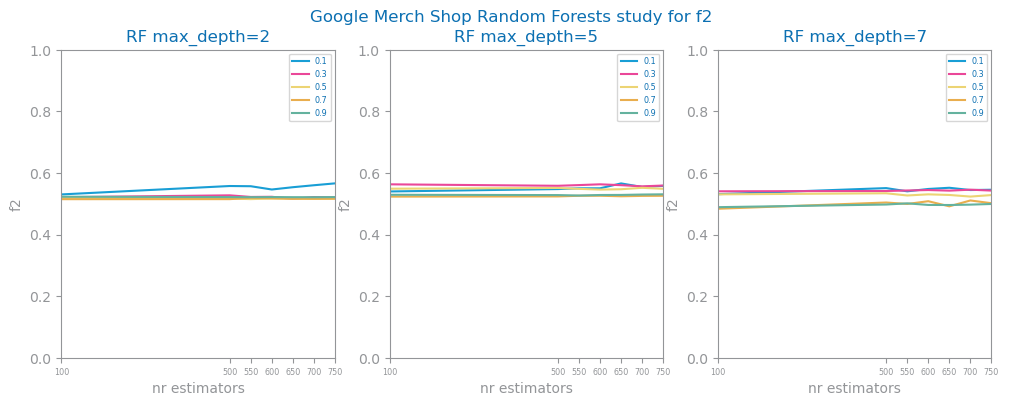

In [59]:

figure()


best_model_f2, f2_params = random_forests_study(
trnX,
trnY,
tstX,
tstY,
nr_max_trees=max_trees_eval,
lag=max_trees_eval_lag,
metric='f2',
file_tag=file_tag
)

savefig(f'images/{file_tag}_rf_{f2_params['metric']}_study.png')
show()
    

## f2 Best Model Performance

<Figure size 640x480 with 0 Axes>

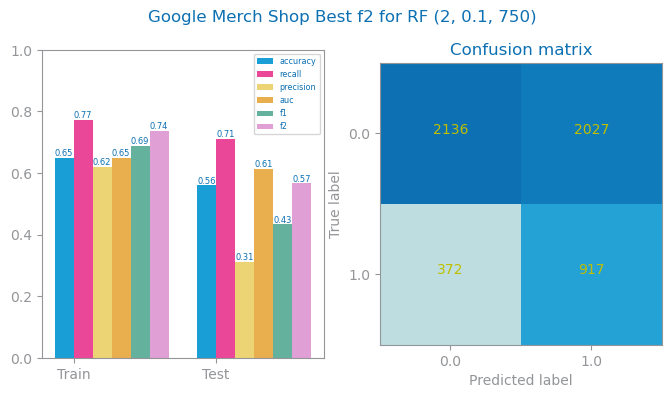

In [60]:
if evaluate == True:
    prd_trn: array = best_model_f2.predict(trnX)
    prd_tst: array = best_model_f2.predict(tstX)
    figure()
    plot_evaluation_results(f2_params, trnY, prd_trn, tstY, prd_tst, labels, file_tag=file_tag)
    savefig(f'images/{file_tag}_rf_{f2_params["name"]}_best_{f2_params["metric"]}_eval.png')
    show()

## f2 Variables importance


1. engagement_time_msec (0.12205376778644446)
2. traffic_source_medium (0.1191112506449688)
3. event_name (0.1169172960827483)
4. session_engaged (0.11543875690222266)
5. traffic_source_source (0.10067410111868905)
6. day_of_year (0.07894745103936757)
7. device_language (0.0727896092666374)
8. page_path_level_1 (0.05019297449410074)
9. geo_city (0.048174939632150714)
10. path_length (0.03703508724909832)
11. is_weekend (0.032556735114906955)
12. local_minute_cos (0.031384017875259)
13. local_minute_sin (0.02930425772514595)
14. geo_region (0.02592687333868355)
15. geo_country (0.01949288172957652)


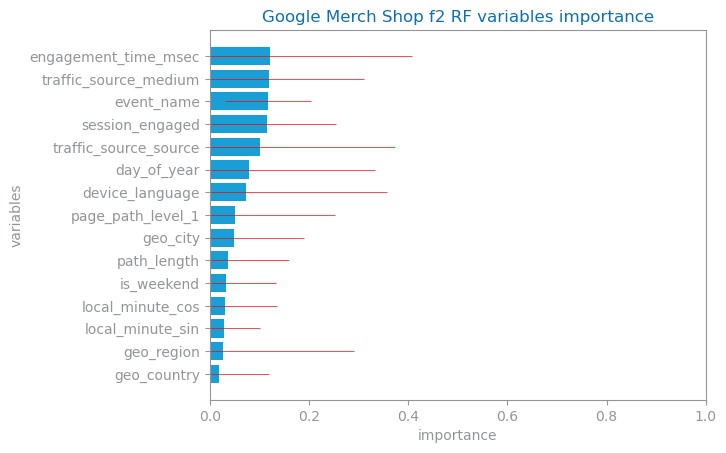

In [61]:
from numpy import std, argsort
from dslabs_functions import plot_horizontal_bar_chart

stdevs: list[float] = list(
    std([tree.feature_importances_ for tree in best_model_f2.estimators_], axis=0)
)
importances = best_model_f2.feature_importances_
indices: list[int] = argsort(importances)[::-1]
elems: list[str] = []
imp_values: list[float] = []
for f in range(len(vars)):
    elems += [vars[indices[f]]]
    imp_values.append(importances[indices[f]])
    print(f"{f+1}. {elems[f]} ({importances[indices[f]]})")

figure()
plot_horizontal_bar_chart(
    elems,
    imp_values,
    error=stdevs,
    title=f"{file_tag} {f2_params["metric"]} RF variables importance",
    xlabel="importance",
    ylabel="variables",
    percentage=True,
)
savefig(f"images/{file_tag}_rf_{f2_params["metric"]}_vars_ranking.png")

## f2 Overfitting

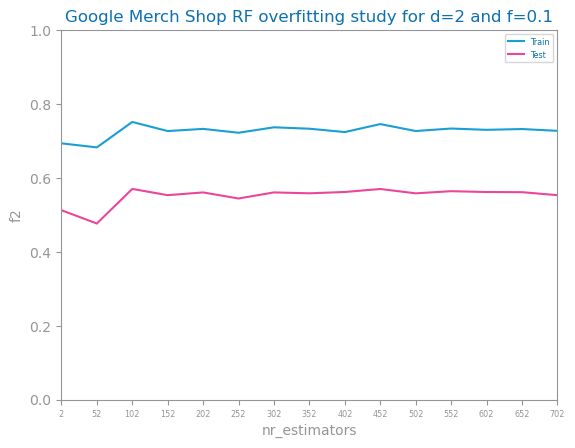

In [62]:
d_max: int = f2_params["params"][0]
feat: float = f2_params["params"][1]
nr_estimators: list[int] = [i for i in range(2, max_trees_eval, max_trees_eval_lag)]

y_tst_values: list[float] = []
y_trn_values: list[float] = []
eval_metric = f2_params["metric"]

for n in nr_estimators:
    clf = RandomForestClassifier(n_estimators=n, max_depth=d_max, max_features=feat)
    clf.fit(trnX, trnY)
    prd_tst_Y: array = clf.predict(tstX)
    prd_trn_Y: array = clf.predict(trnX)
    y_tst_values.append(CLASS_EVAL_METRICS[eval_metric](tstY, prd_tst_Y))
    y_trn_values.append(CLASS_EVAL_METRICS[eval_metric](trnY, prd_trn_Y))

figure()
plot_multiline_chart(
    nr_estimators,
    {"Train": y_trn_values, "Test": y_tst_values},
    title=f"{file_tag} RF overfitting study for d={d_max} and f={feat}",
    xlabel="nr_estimators",
    ylabel=str(eval_metric),
    percentage=True,
)
savefig(f"images/{file_tag}_rf_{eval_metric}_overfitting.png")

# Precision Model Evaluation

## precision study

RF best for 700 trees (d=5 and f=0.9)


<Figure size 640x480 with 0 Axes>

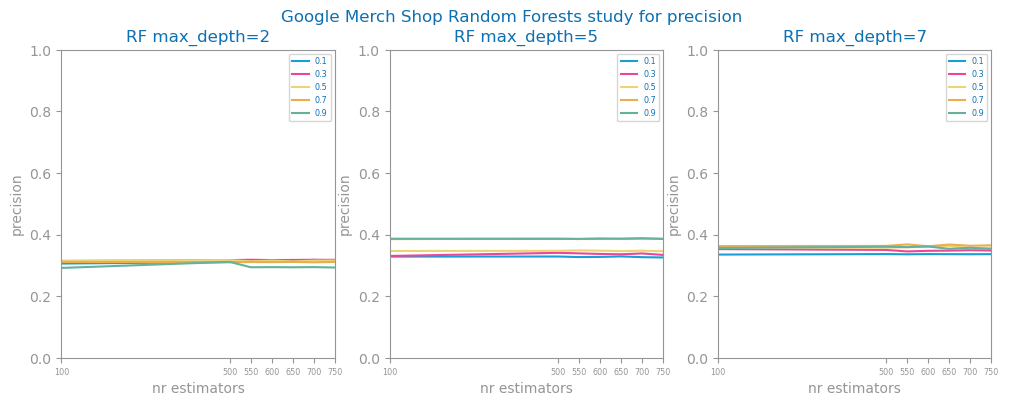

In [63]:

figure()

best_model_prec, prec_params = random_forests_study(
trnX,
trnY,
tstX,
tstY,
nr_max_trees=max_trees_eval,
lag=max_trees_eval_lag,
metric='precision',
file_tag=file_tag
)

savefig(f'images/{file_tag}_rf_{prec_params["metric"]}_study.png')
show()

## precision best model performance

<Figure size 640x480 with 0 Axes>

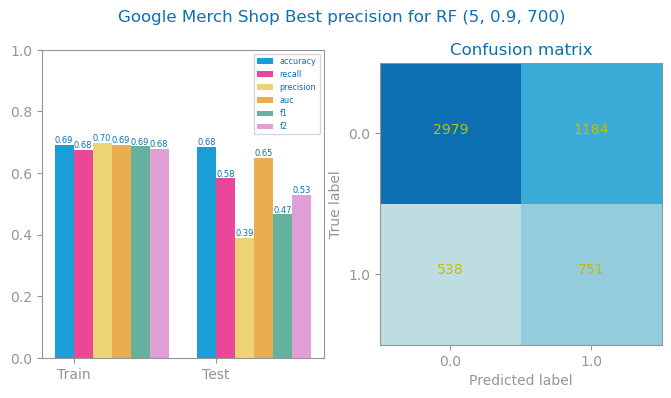

In [64]:
if evaluate == True:
    prd_trn: array = best_model_prec.predict(trnX)
    prd_tst: array = best_model_prec.predict(tstX)
    figure()
    plot_evaluation_results(prec_params, trnY, prd_trn, tstY, prd_tst, labels,file_tag=file_tag)
    savefig(f'images/{file_tag}_rf_{prec_params["name"]}_best_{prec_params["metric"]}_eval.png')
    show()

## precision variables importance

1. event_name (0.4908565959705821)
2. traffic_source_source (0.2261453091908028)
3. traffic_source_medium (0.14761977328078582)
4. page_path_level_1 (0.07291350729261487)
5. engagement_time_msec (0.028861276786698073)
6. day_of_year (0.009199123738070334)
7. geo_city (0.006752226071276206)
8. device_language (0.004079572519836724)
9. path_length (0.0034566484204091685)
10. local_minute_cos (0.003082044061031498)
11. geo_region (0.0028741503458232327)
12. local_minute_sin (0.0022775727011332745)
13. session_engaged (0.0014262336173157507)
14. is_weekend (0.0002873480458267001)
15. geo_country (0.0001686179577934847)


<Axes: title={'center': 'Google Merch Shop precision RF variables importance'}, xlabel='importance', ylabel='variables'>

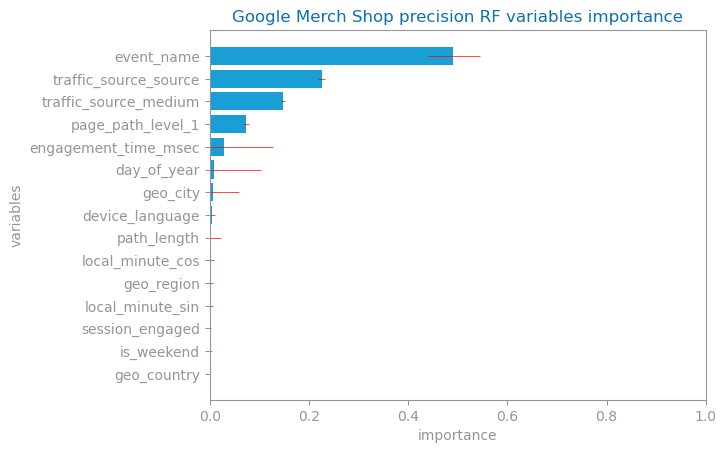

In [65]:
from numpy import std, argsort
from dslabs_functions import plot_horizontal_bar_chart

stdevs: list[float] = list(
    std([tree.feature_importances_ for tree in best_model_prec.estimators_], axis=0)
)
importances = best_model_prec.feature_importances_
indices: list[int] = argsort(importances)[::-1]
elems: list[str] = []
imp_values: list[float] = []
for f in range(len(vars)):
    elems += [vars[indices[f]]]
    imp_values.append(importances[indices[f]])
    print(f"{f+1}. {elems[f]} ({importances[indices[f]]})")

figure()
plot_horizontal_bar_chart(
    elems,
    imp_values,
    error=stdevs,
    title=f"{file_tag} {prec_params["metric"]} RF variables importance",
    xlabel="importance",
    ylabel="variables",
    percentage=True,
)

## precision overfitting

<Axes: title={'center': 'Google Merch Shop RF overfitting study for d=5 and f=0.9'}, xlabel='nr_estimators', ylabel='precision'>

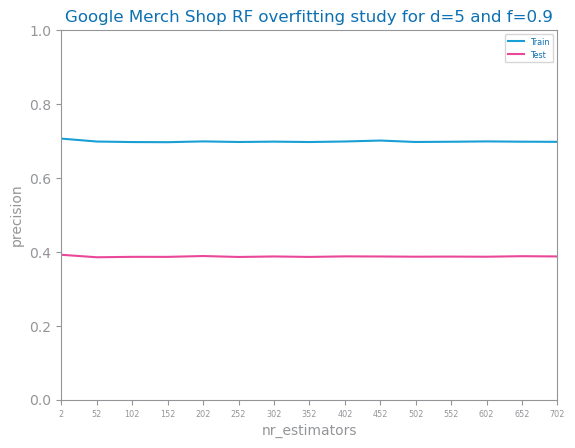

In [66]:
d_max: int = prec_params["params"][0]
feat: float = prec_params["params"][1]
nr_estimators: list[int] = [i for i in range(2, max_trees_eval, max_trees_eval_lag)]

y_tst_values: list[float] = []
y_trn_values: list[float] = []
eval_metric = prec_params["metric"]

for n in nr_estimators:
    clf = RandomForestClassifier(n_estimators=n, max_depth=d_max, max_features=feat)
    clf.fit(trnX, trnY)
    prd_tst_Y: array = clf.predict(tstX)
    prd_trn_Y: array = clf.predict(trnX)
    y_tst_values.append(CLASS_EVAL_METRICS[eval_metric](tstY, prd_tst_Y))
    y_trn_values.append(CLASS_EVAL_METRICS[eval_metric](trnY, prd_trn_Y))

figure()
plot_multiline_chart(
    nr_estimators,
    {"Train": y_trn_values, "Test": y_tst_values},
    title=f"{file_tag} RF overfitting study for d={d_max} and f={feat}",
    xlabel="nr_estimators",
    ylabel=str(eval_metric),
    percentage=True,
)

# Analysis

- Traffic source and medium with higher importance
- overfitting from level 3
